# News Aggregator
### model for news headline classification

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np 
import pandas as pd 
import tensorflow as tf
import string

In [2]:
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


### Data set from kaggle
###### https://www.kaggle.com/uciml/news-aggregator-dataset

In [4]:
data = pd.read_csv('uci-news-aggregator.csv', usecols=['TITLE', 'CATEGORY'])

In [5]:
data.head()

,TITLE,CATEGORY
0,"Fed official says weak data caused by weather,...",b
1,Fed's Charles Plosser sees high bar for change...,b
2,US open: Stocks fall after Fed official hints ...,b
3,"Fed risks falling 'behind the curve', Charles ...",b
4,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,b


In [6]:
# A look at how many records we have per category
data.CATEGORY.value_counts()

e    152469
b    115967
t    108344
m     45639
Name: CATEGORY, dtype: int64

In [7]:
# taking the maximum chunk of every category
num_of_categories = 45000

In [8]:
# suffling the data frame
shuffled = data.reindex(np.random.permutation(data.index))
# seperating each category equally
e = shuffled[shuffled['CATEGORY'] == 'e'][:num_of_categories]
b = shuffled[shuffled['CATEGORY'] == 'b'][:num_of_categories]
t = shuffled[shuffled['CATEGORY'] == 't'][:num_of_categories]
m = shuffled[shuffled['CATEGORY'] == 'm'][:num_of_categories]
# combining all the categories to a data frame
concated = pd.concat([e,b,t,m], ignore_index=True)
# Re-Shuffling the dataset
concated = concated.reindex(np.random.permutation(concated.index))
# making a LABEL column and filling with 0
concated['LABEL'] = 0

In [9]:
concated.head()

,TITLE,CATEGORY,LABEL
151004,Vaccines have low risk of serious side effects...,m,0
64804,World stocks recover after strong US data - KT...,b,0
102397,Laser-powered particle accelerators could cut ...,t,0
64767,Euro Exposed to Fresh Lows As Draghi Invites N...,b,0
44712,"Noël Wells, John Milhiser: 'Saturday Night Liv...",e,0


In [10]:
# numerical map of categories to label
concated.loc[concated['CATEGORY'] == 'e', 'LABEL'] = 0
concated.loc[concated['CATEGORY'] == 'b', 'LABEL'] = 1
concated.loc[concated['CATEGORY'] == 't', 'LABEL'] = 2
concated.loc[concated['CATEGORY'] == 'm', 'LABEL'] = 3
# making a label column in to a One Hot Encoding
labels = tf.keras.utils.to_categorical(concated['LABEL'], num_classes=4)

In [11]:
concated.head()

,TITLE,CATEGORY,LABEL
151004,Vaccines have low risk of serious side effects...,m,3
64804,World stocks recover after strong US data - KT...,b,1
102397,Laser-powered particle accelerators could cut ...,t,2
64767,Euro Exposed to Fresh Lows As Draghi Invites N...,b,1
44712,"Noël Wells, John Milhiser: 'Saturday Night Liv...",e,0


In [12]:
# a ruff estimate of the number of features
n_most_common_words = 8000
# max len for padding
max_len = 130
# creating a tokenizer
tokenizer = Tokenizer(num_words=n_most_common_words, filters=string.punctuation, lower=True)
# making the tokenizer train on our text i,e News Headlines
tokenizer.fit_on_texts(concated['TITLE'].values)
# Transforming out text into an integer sequence i.e list
sequences = tokenizer.texts_to_sequences(concated['TITLE'].values)
# Padding the lists to level the playfield
X = pad_sequences(sequences, maxlen=max_len)

In [13]:
# Splitting considered data into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)

In [14]:
# no of Epochs for Model Training
epochs = 10
# Output Dimensions for Embedded Layer
emb_dim = 128
# Batch size for training
batch_size = 256

In [16]:
# Creating a LSTM model
model = tf.keras.Sequential()
model.add(layers.Embedding(n_most_common_words, emb_dim, input_length=X_train.shape[1]))
model.add(layers.SpatialDropout1D(0.5, ))
model.add(layers.LSTM(64, dropout=0.7, recurrent_dropout=0.7, ))
model.add(layers.Dense(4, activation='softmax'))

In [17]:
# compiling the layer 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 130, 128)          1024000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 130, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 1,073,668
Trainable params: 1,073,668
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
# Training the model 
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

Train on 108000 samples, validate on 27000 samples
Epoch 1/10
108000/108000 [==============================] - 171s 2ms/sample - loss: 0.7541 - accuracy: 0.7106 - val_loss: 0.3014 - val_accuracy: 0.8962
Epoch 2/10
108000/108000 [==============================] - 177s 2ms/sample - loss: 0.3177 - accuracy: 0.8918 - val_loss: 0.2434 - val_accuracy: 0.9161
Epoch 3/10
108000/108000 [==============================] - 182s 2ms/sample - loss: 0.2612 - accuracy: 0.9117 - val_loss: 0.2245 - val_accuracy: 0.9229
Epoch 4/10
108000/108000 [==============================] - 181s 2ms/sample - loss: 0.2345 - accuracy: 0.9208 - val_loss: 0.2180 - val_accuracy: 0.9250
Epoch 5/10
108000/108000 [==============================] - 183s 2ms/sample - loss: 0.2167 - accuracy: 0.9262 - val_loss: 0.2160 - val_accuracy: 0.9269
Epoch 6/10
108000/108000 [==============================] - 181s 2ms/sample - loss: 0.2066 - accuracy: 0.9297 - val_loss: 0.2115 - val_accuracy: 0.9273
Epoch 7/10
108000/108000 [===========

In [20]:
# model = tf.keras.models.load_model('News_Aggregator_LSTM_v1.h5')

In [21]:
# Evaluating the model against the test data
accr = model.evaluate(X_test,y_test, verbose=0);
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.205
  Accuracy: 0.932


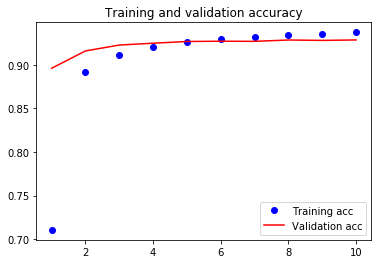

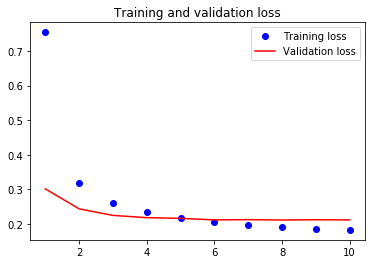

In [22]:
# Visuaizing how accuracy and loss progressed
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
# Evaluation
txt = ["Regular fast food eating linked to fertility issues in women"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['entertainment', 'bussiness', 'science/tech', 'health']
print(pred, labels[np.argmax(pred)])

[[4.6327408e-05 1.9420726e-04 5.0750048e-05 9.9970871e-01]] health
